# Histopathologic Cancer Detection

## Topic

The aim of this project is to develop a cutting-edge deep learning algorithm capable of accurately identifying metastatic cancer in small image patches extracted from larger digital pathology scans. Metastatic cancer, the spread of cancer cells from the primary tumor to other parts of the body, is a critical factor in cancer prognosis and treatment planning. However, manually analyzing large-scale pathology scans to detect metastatic cancer can be time-consuming and prone to human error.

In this project, I am going to use deep learning algorithm (CNN), including data processing, model traing, model testing and model improving, to identify metastatic cancer in small image patches.

[Github Repo](https://github.com/BaffinLee/Histopathologic-Cancer-Detection)


In [53]:
import numpy as np
import pandas as pd
import os

# use smaller dataset during developing, full dataset for kaggle
IS_DEV = os.environ['KAGGLE_KERNEL_RUN_TYPE'] == 'Interactive'

## Data

The dataset is from [kaggle](https://www.kaggle.com/competitions/histopathologic-cancer-detection).

It contains 220,025 training image patches from larger digital pathology scans with label (classfication of cancer) and 57,458 testing images.

All the training image ids and labels are in the train_labels.csv file, all the image files are located in train and test folder, with the file name's pattern: "{image_id}.tif".

Let's load the training dataset and take a look at the data structure.

In [54]:
base_path = '/kaggle/input/histopathologic-cancer-detection'
df = pd.read_csv(f'{base_path}/train_labels.csv')
print(df.info())
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 220025 entries, 0 to 220024
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   id      220025 non-null  object
 1   label   220025 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 3.4+ MB
None


,id,label
0,f38a6374c348f90b587e046aac6079959adf3835,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1
2,755db6279dae599ebb4d39a9123cce439965282d,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0
4,068aba587a4950175d04c680d38943fd488d6a9d,0


In [55]:
import cv2

def load_image_data(df, num):
    X = np.zeros([num,96,96,3],dtype=np.uint8)
    y = np.array(df.label[0:num])
    for i in range(num):
        X[i] = cv2.imread(f'{base_path}/train/{df.id[i]}.tif')
    return X, y

In [56]:
from sklearn.model_selection import train_test_split

train_size = 3000 if IS_DEV else 10000
X, y = load_image_data(df, train_size)

## Exploratory Data Analysis (EDA)

Before we train our model, let's inspect the dataset, do some visualizing and clean it.

### Inspect data

We loaded the training data into numpy arrays, every image is 96x96 resolution, with RGB color in the range of 0 ~ 255.

In [57]:
print(X.shape)
print(X[0][0][:10])

print(y.shape)
print(y[:10])

(3000, 96, 96, 3)
[[244 246 246]
 [245 247 247]
 [246 248 249]
 [247 249 250]
 [247 249 250]
 [246 248 249]
 [245 247 248]
 [244 245 249]
 [242 243 247]
 [242 243 247]]
(3000,)
[0 1 0 0 0 0 1 1 0 0]


### Data cleaning

As we mentioned before, this dataset is from kaggle. According to the kaggle competition page, the dataset has already been cleaned, there is no empty data point or duplication.

So I will just simply verify it here.

In [58]:
print(np.isnan(X).any())
print(np.isnan(y).any())

False
False


### Data visualization

We will plot some charts to help us have a better undestading of the dataset.

First of all, let's view some random images from the dataset.

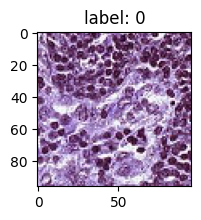

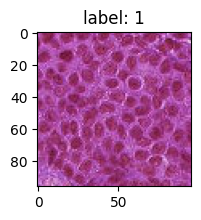

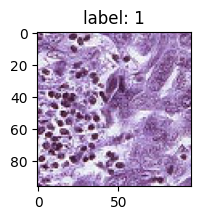

In [59]:
import matplotlib.pyplot as plt

for i in range(3):
    idx = np.random.randint(0, train_size)
    fig = plt.figure(figsize=(2, 2))
    plt.imshow(X[idx])
    plt.title(f'label: {df.label[idx]}')
    fig.show()

Then, let's see how the cancer labels distributes. Through the plot we know that there are a little bit more normal images than images with cencer. There are about 60% of normal images, which means even our algorithm predict every image to be normal image without cencer, it will get 0.6 accuracy. So it will be better our model's accuracy is better than 0.6

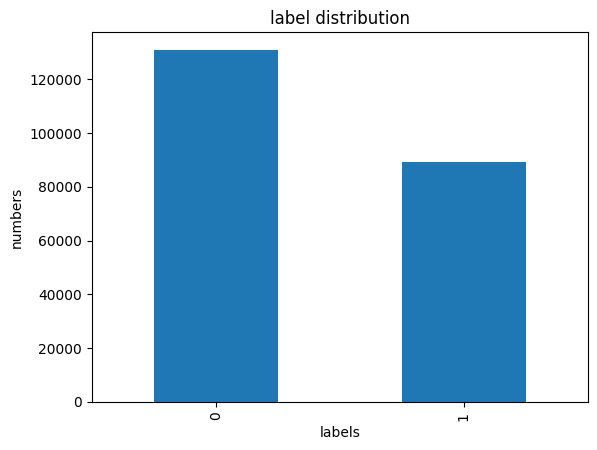

In [60]:
df.label.value_counts().plot(kind='bar')
plt.title('label distribution')
plt.xlabel('labels')
plt.ylabel('numbers')
plt.show()

Because the images from this dataset is colored images, let's analyse the distribution of RGBs for normal images and cancer images.

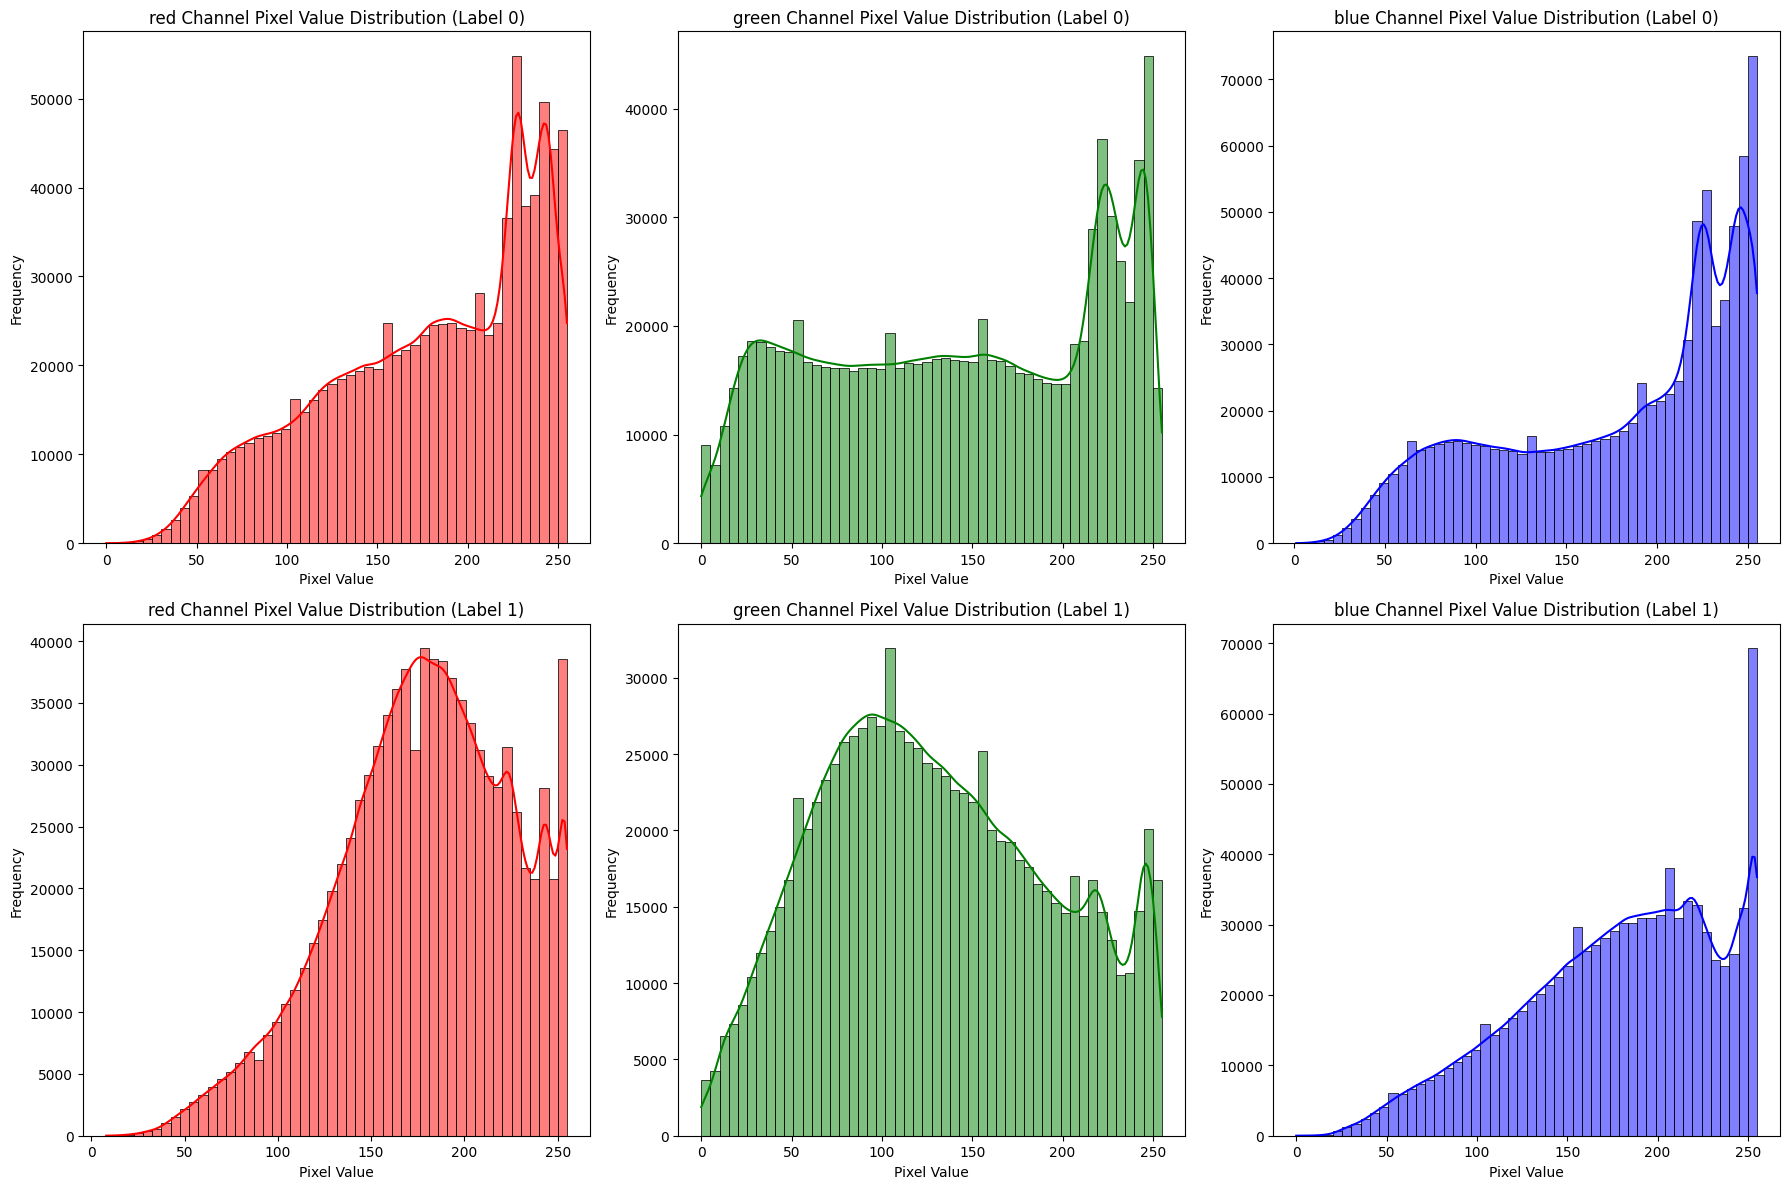

In [61]:
import seaborn as sns
import warnings

warnings.filterwarnings('ignore', category=FutureWarning, message=".*use_inf_as_na.*")

plt.figure(figsize=(18, 12))

for i in range(2):
    images = [img for img, label in zip(X, y) if label == i][:100]
    for (j, t) in zip(range(3), ['red', 'green', 'blue']):
        values = np.concatenate([img[:, :, j].ravel() for img in images])
        plt.subplot(2, 3, (i * 3) + j + 1)
        sns.histplot(values, bins=50, kde=True, color=t)
        plt.title(f'{t} Channel Pixel Value Distribution (Label {i})')
        plt.xlabel('Pixel Value')
        plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

As we can see from those plots above, images with cancer seem to have higher pixel values (more bright) in general. Images in this dataset is light colored in general (with more higher pixel valuess, like 255).

This give a tip to clean our data, if we find total dark or too bright images, we probably want to remove that images from dataset.

## Model

We'll use a simple Convolutional Neural Network (CNN) for the binary classification task.

I am going to split the trainging data into train and validate data, with 20% of data for validation.

In [62]:
train_images, val_images, train_labels, val_labels = train_test_split(X, y, test_size=0.2, random_state=42)

In [63]:
import warnings

warnings.filterwarnings('ignore', category=FutureWarning, message=".*already been registered.*")

In the following section, I will use Sequential from keras library to build our model.

### Model Architecture

- Input Layer: (96, 96, 3) - Input images are 96x96 pixels with 3 color channels.
- Conv2D + ReLU: 32 filters (3x3) - Extract basic features.
- MaxPooling2D: (2x2) - Downsample feature maps.
- Conv2D + ReLU: 64 filters (3x3) - Extract more complex features.
- MaxPooling2D: (2x2) - Downsample.
- Conv2D + ReLU: 128 filters (3x3) - Extract even more detailed features.
- MaxPooling2D: (2x2) - Downsample.
- Conv2D + ReLU: 128 filters (3x3) - Further feature extraction.
- MaxPooling2D: (2x2) - Final downsample.
- Flatten: Convert 3D feature maps to 1D vector.
- Dense + ReLU: 512 units - Learn feature combinations.
- Dropout: 0.5 - Prevent overfitting.
- Dense + Sigmoid: 1 unit - Output for binary classification.

This model architecture will progressively extract and combine features from images, reducing their spatial dimensions while preserving important information, ultimately making a binary classification decision. The use of multiple convolutional and pooling layers enables the model to learn hierarchical feature representations, while the dropout layer helps mitigate overfitting.

In [64]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input

model = Sequential([
    Input((96, 96, 3)),
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')  # Sigmoid for binary classification
])

### Compile and train the model.

In [65]:
model.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

In [66]:
history = model.fit(
    train_images, train_labels,
    epochs=10,
    batch_size=32,
    validation_data=(val_images, val_labels)
)

Epoch 1/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 27s 331ms/step - accuracy: 0.5719 - loss: 9.4422 - val_accuracy: 0.5617 - val_loss: 0.6865
Epoch 2/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 24s 321ms/step - accuracy: 0.6181 - loss: 0.6738 - val_accuracy: 0.5617 - val_loss: 0.6871
Epoch 3/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 24s 320ms/step - accuracy: 0.5956 - loss: 0.6749 - val_accuracy: 0.5617 - val_loss: 0.6889
Epoch 4/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 40s 313ms/step - accuracy: 0.6098 - loss: 0.6699 - val_accuracy: 0.5617 - val_loss: 0.6899
Epoch 5/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 41s 308ms/step - accuracy: 0.5973 - loss: 0.6742 - val_accuracy: 0.5617 - val_loss: 0.6897
Epoch 6/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 24s 322ms/step - accuracy: 0.6084 - loss: 0.6697 - val_accuracy: 0.5617 - val_loss: 0.6906
Epoch 7/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 41s 320ms/step - accuracy: 0.6044 - loss: 0.6715 - val_accuracy: 0.5617 - val_loss: 0.6900
Epoch 8/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 41s 325ms/step - accuracy: 0.5935 - loss: 0.6777 - val_accu

### Evaluate the Model

Let's display the validate loss and validate accuracy. This model has 0.56 accuracy when I only use 3000 images for training to reduce training time in development. It's obvious the accuracy is not good, because the baseline model can have 0.6 accuracy by predicting every image to be negative. I will use more images to train the model after submiting this code to kaggle, (I did get better accuracy in the kaggle submition), let's just ignore it for now.

Then I ploted the training accuracy and validation accuracy in every epochs. As the plot tells, our epoch number is not bigger enough to fit the model, I think the model is underfitting.

I will try to improve this model's accuracy in the following section. 

19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 83ms/step - accuracy: 0.5538 - loss: 0.6964
Validation Loss: 0.6926000118255615
Validation Accuracy: 0.5616666674613953


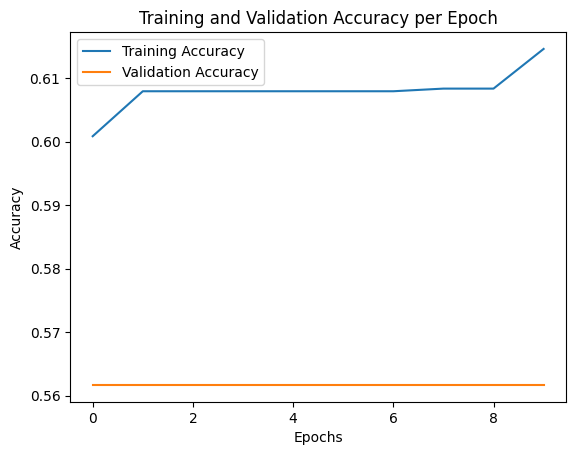

In [67]:
def show_model_metrics():
    val_loss, val_acc = model.evaluate(val_images, val_labels)
    print(f'Validation Loss: {val_loss}')
    print(f'Validation Accuracy: {val_acc}')

    train_accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']

    # Plot accuracy and validation accuracy
    plt.plot(train_accuracy, label='Training Accuracy')
    plt.plot(val_accuracy, label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy per Epoch')
    plt.legend()
    plt.show()
    
show_model_metrics()

## Results and Analysis

### Hyperparameter tuning

We have tried epoch=10 to train the model and it's likely the model is underfit. Let's try bigger epoch to train the model and evalute it.

After we increased the epoch number, the model performance improved. But in the plot we can find out that our model is likely overfitting after the apoch is too big. In the end of this training process, the validation accuracy stoped going up, which means our model is probably overfiting. So it's really important to pick a right epoch number. 

Epoch 1/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 26s 319ms/step - accuracy: 0.5730 - loss: 11.3814 - val_accuracy: 0.6600 - val_loss: 0.6184
Epoch 2/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 24s 318ms/step - accuracy: 0.6958 - loss: 0.5833 - val_accuracy: 0.7400 - val_loss: 0.5896
Epoch 3/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 23s 308ms/step - accuracy: 0.7337 - loss: 0.5473 - val_accuracy: 0.7567 - val_loss: 0.5723
Epoch 4/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 24s 315ms/step - accuracy: 0.7423 - loss: 0.5382 - val_accuracy: 0.7000 - val_loss: 0.5801
Epoch 5/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 24s 314ms/step - accuracy: 0.7404 - loss: 0.5366 - val_accuracy: 0.6950 - val_loss: 0.5890
Epoch 6/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 41s 321ms/step - accuracy: 0.7707 - loss: 0.5012 - val_accuracy: 0.7633 - val_loss: 0.5167
Epoch 7/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 23s 312ms/step - accuracy: 0.7772 - loss: 0.4752 - val_accuracy: 0.7217 - val_loss: 0.6011
Epoch 8/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 24s 322ms/step - accuracy: 0.7367 - loss: 0.5288 - val_acc

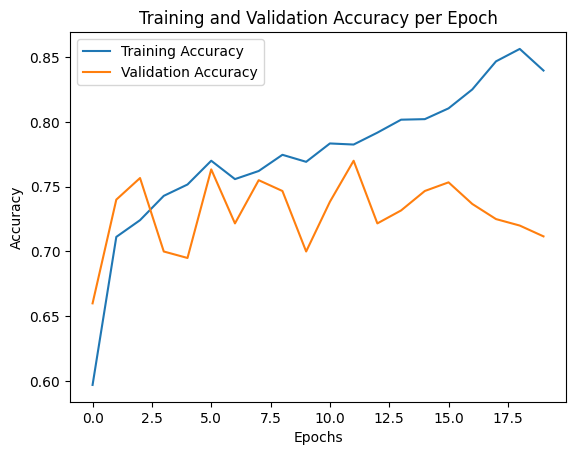

In [68]:
model = Sequential([
    Input((96, 96, 3)),
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')  # Sigmoid for binary classification
])

model.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

history = model.fit(
    train_images, train_labels,
    epochs=20,
    batch_size=32,
    validation_data=(val_images, val_labels)
)

show_model_metrics()

Let's try dynamic learning rato, see if we can improve the model's performance.

Epoch 1/15
75/75 ━━━━━━━━━━━━━━━━━━━━ 25s 305ms/step - accuracy: 0.5515 - loss: 7.7154 - val_accuracy: 0.5617 - val_loss: 0.6927 - learning_rate: 0.0010
Epoch 2/15
75/75 ━━━━━━━━━━━━━━━━━━━━ 22s 298ms/step - accuracy: 0.6763 - loss: 0.5912 - val_accuracy: 0.7367 - val_loss: 0.5997 - learning_rate: 0.0010
Epoch 3/15
75/75 ━━━━━━━━━━━━━━━━━━━━ 42s 314ms/step - accuracy: 0.6955 - loss: 0.5907 - val_accuracy: 0.7467 - val_loss: 0.5564 - learning_rate: 0.0010
Epoch 4/15
75/75 ━━━━━━━━━━━━━━━━━━━━ 23s 304ms/step - accuracy: 0.7482 - loss: 0.5394 - val_accuracy: 0.5550 - val_loss: 0.6835 - learning_rate: 0.0010
Epoch 5/15
75/75 ━━━━━━━━━━━━━━━━━━━━ 24s 315ms/step - accuracy: 0.6128 - loss: 0.6382 - val_accuracy: 0.7450 - val_loss: 0.5490 - learning_rate: 0.0010
Epoch 6/15
75/75 ━━━━━━━━━━━━━━━━━━━━ 23s 304ms/step - accuracy: 0.7640 - loss: 0.5096 - val_accuracy: 0.7350 - val_loss: 0.5394 - learning_rate: 0.0010
Epoch 7/15
75/75 ━━━━━━━━━━━━━━━━━━━━ 41s 307ms/step - accuracy: 0.7557 - loss: 0.

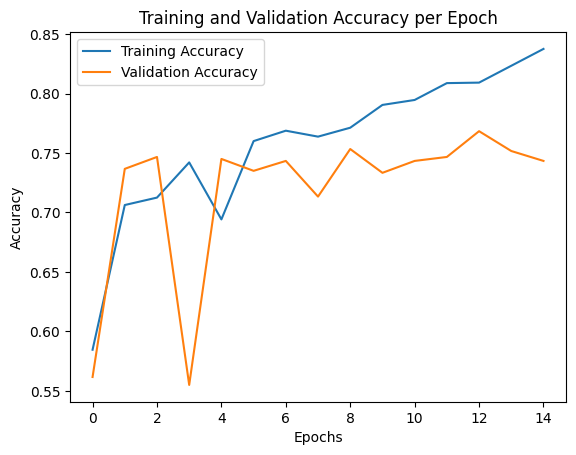

In [69]:
from keras.callbacks import LearningRateScheduler

model = Sequential([
    Input((96, 96, 3)),
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')  # Sigmoid for binary classification
])

model.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

# Define a learning rate schedule function
def step_decay(epoch):
    initial_lr = 0.001
    drop = 0.5
    epochs_drop = 10
    lr = initial_lr * np.power(drop, np.floor((1+epoch)/epochs_drop))
    return lr

# Create a LearningRateScheduler callback
lr_scheduler = LearningRateScheduler(step_decay)

history = model.fit(
    train_images, train_labels,
    epochs=15,
    batch_size=32,
    validation_data=(val_images, val_labels),
    callbacks=[lr_scheduler]
)

show_model_metrics()

### Other Model Architecture

Let's try an more complex model architecture to train our model and compare it to the original one. The new model has more layers to extract feature, hopefully it will perform better.

Epoch 1/15
75/75 ━━━━━━━━━━━━━━━━━━━━ 57s 686ms/step - accuracy: 0.6846 - loss: 0.7713 - val_accuracy: 0.5617 - val_loss: 7.4386
Epoch 2/15
75/75 ━━━━━━━━━━━━━━━━━━━━ 48s 645ms/step - accuracy: 0.7464 - loss: 0.6308 - val_accuracy: 0.5633 - val_loss: 1.5790
Epoch 3/15
75/75 ━━━━━━━━━━━━━━━━━━━━ 81s 637ms/step - accuracy: 0.7445 - loss: 0.6728 - val_accuracy: 0.5633 - val_loss: 1.8443
Epoch 4/15
75/75 ━━━━━━━━━━━━━━━━━━━━ 48s 638ms/step - accuracy: 0.7575 - loss: 0.6011 - val_accuracy: 0.6500 - val_loss: 0.7176
Epoch 5/15
75/75 ━━━━━━━━━━━━━━━━━━━━ 48s 645ms/step - accuracy: 0.8048 - loss: 0.4817 - val_accuracy: 0.6567 - val_loss: 0.7503
Epoch 6/15
75/75 ━━━━━━━━━━━━━━━━━━━━ 83s 655ms/step - accuracy: 0.8199 - loss: 0.3957 - val_accuracy: 0.5850 - val_loss: 1.1255
Epoch 7/15
75/75 ━━━━━━━━━━━━━━━━━━━━ 82s 657ms/step - accuracy: 0.8377 - loss: 0.3988 - val_accuracy: 0.7300 - val_loss: 0.5395
Epoch 8/15
75/75 ━━━━━━━━━━━━━━━━━━━━ 82s 661ms/step - accuracy: 0.8524 - loss: 0.3489 - val_accu

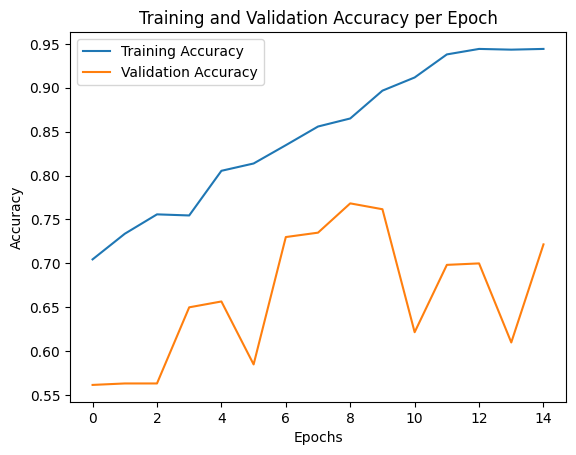

In [70]:
from tensorflow.keras.layers import BatchNormalization

model = Sequential([
    Input((96, 96, 3)),
    Conv2D(32, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2, 2),
    
    Conv2D(64, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2, 2),
    
    Conv2D(128, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2, 2),
    
    Conv2D(256, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2, 2),
    
    Conv2D(512, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2, 2),
    
    Flatten(),
    Dense(1024, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')  # Sigmoid for binary classification
])

# Compile the new model
model.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

# Train the new model
history = model.fit(
    train_images, train_labels,
    epochs=15,
    batch_size=32,
    validation_data=(val_images, val_labels)
)

show_model_metrics()

### Summary

In the above section, we tried numbers of ways to improve our model performance. The validation accuracy of each hyperparameter tuning process is:

| Model  |  Validation Accuracy |
|---|---|
| epoch=10  | 0.5616  |
| epoch=20  | 0.7116  |
| epoch=15, dynamic leraning rate  | 0.7433  |
| epoch=15, new architecture  | 0.7216  |

Please be aware that I use less images in training process while developing, to reduce wating time, so the final result on kaggle will be much different (and better) than this.

## Conclusion

This project covers loading images from files, building a binary classifier, training, and evaluating the model.

We did lot's hyperparameter tuning, some of them helps like dynamic learning rate, some of them will cause model underfit or overfit like epoch number. More layers in model architecture might not help depending on the design and dataset's domain knowledge.

The number of datapoints used in traing and validating process will alse effect the model performance, as I use less training data in developing, the result is not great, while using more data to train get a better result.

### Submit Kaggle Competition

In [71]:
import math

test_image_files = list(map(lambda x: x.split('/').pop().split(".")[0], os.listdir(f'{base_path}/test')))
if IS_DEV:
    test_image_files = test_image_files[:100]

submission = pd.DataFrame(columns=['id', 'label'])
batch_size = 5000
test_size = len(test_image_files)

for i in range(math.ceil(test_size / batch_size)):
    print(f'batch {i}')
    ids = test_image_files[(i * batch_size):((i + 1) * batch_size)]
    test_images = np.zeros([len(ids),96,96,3],dtype=np.uint8)
    for i in range(len(ids)):
        test_images[i] = cv2.imread(f'{base_path}/test/{ids[i]}.tif')
    predictions = model.predict(test_images)
    test_df = pd.DataFrame({
        'id': ids,
        'label': [item[0] for item in predictions],
    })
    submission = pd.concat([
        None if submission.empty else submission,
        test_df,
    ], ignore_index=True)

submission.head()

batch 0
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 138ms/step


,id,label
0,a7ea26360815d8492433b14cd8318607bcf99d9e,0.001935
1,59d21133c845dff1ebc7a0c7cf40c145ea9e9664,0.000134
2,5fde41ce8c6048a5c2f38eca12d6528fa312cdbb,0.099776
3,bd953a3b1db1f7041ee95ff482594c4f46c73ed0,0.022214
4,523fc2efd7aba53e597ab0f69cc2cbded7a6ce62,0.964920


In [72]:
submission.to_csv("submission.csv", index = False, header = True)